# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import numpy as np
import ast
import math
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

In [3]:
df = pd.read_csv('main_task.xls')

Common functions

In [4]:
# Replace value with value
def replaceValues(value, data):
  if (value == data[0]):
    return data[1]
  return value;

  

def removeBigValues(value, data):
  if (value > data[0]): return data[0]
  return value

In [5]:
# Consts
list_of_cities = df['City'].unique()
print("Amount of unique cities:", len(list_of_cities))

Amount of unique cities: 31


In [6]:
# Create extra columns for missing values
df['Number_of_Reviews_isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')
# Get missing "Price Range"
df['Price_Range_isNAN'] = pd.isna(df['Price Range']).astype('uint8')
# Get missing "Cuisine Style"
df['Cuisine_Style_isNAN'] = pd.isna(df['Cuisine Style']).astype('uint8')

Process empty values


In [7]:
# Get mean values by cities
mean_by_city = df.groupby('City')['Number of Reviews'].mean()
# Get index of 'Number of Reviews' column
index_reviews_number = df.columns.get_loc('Number of Reviews')

# Set missing values with avg value per city
for city_name in list_of_cities:
    unique_city_reviews = df[df['City'] == city_name]['Number of Reviews']
    unique_city_reviews = unique_city_reviews.fillna(mean_by_city[city_name])
    for index,value in unique_city_reviews.iteritems():
        df.iat[index, index_reviews_number] = value


# Cast to int
df['Number of Reviews'] = df['Number of Reviews'].astype('int')
# Verify that filled NaN
print('Number of Reviews has NaN values: ', df['Number of Reviews'].isnull().values.any())
display(df.head(3))

Number of Reviews has NaN values:  False


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Number_of_Reviews_isNAN,Price_Range_isNAN,Cuisine_Style_isNAN
0,id_5569,Paris,"['European', 'French', 'International']",5570,3.5,$$ - $$$,194,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,0,0
1,id_1535,Stockholm,NaN,1537,4.0,NaN,10,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,0,1,1
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353,4.5,$$$$,688,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,0,0,0


In [8]:
display(df['Price Range'].value_counts())

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [9]:
# Ваша обработка 'Price Range'
# Replace $ with numbers
def priceRangeParcer(range):
  if ('nan' in range):
    return float('NaN')
  if (range == '$'): return 1
  if (range == '$$ - $$$'): return 2
  if (range == '$$$$'): return 3



price_range_code = []
# Convert Price Range to string
price_range_code = df['Price Range'].astype(str)
# Convert data to numeric values
price_range_code = price_range_code.apply(priceRangeParcer);
# Convert type to number
price_range_code = price_range_code.astype(float)
# Replace old price range with the new one
df['Price Range'] = price_range_code

# Get mean values by cities
price_mean_by_city = df.groupby('City')['Price Range'].mean()
# Get index of 'Price Range' column
index_price_number = df.columns.get_loc('Price Range')

# Set missing values with avg value per city
for city_name in list_of_cities:
    unique_city_price = df[df['City'] == city_name]['Price Range']
    unique_city_price = unique_city_price.fillna(price_mean_by_city[city_name])
    for index,value in unique_city_price.iteritems():
        df.iat[index, index_price_number] = value

# Cast to int
df['Price Range'] = df['Price Range'].astype('int')
# Verify price range
print('Price Range has NaN values:', df['Price Range'].isnull().values.any())

Price Range has NaN values: False


Add extra columns

In [10]:
# Process Cuisine Style
def tryParseCuisineString(string_value, try_count=0):
  try:
    data = ast.literal_eval(string_value)
  except:
    if (try_count > 0): return []
    # bad solution, but will work for now :)
    return tryParseCuisineString(string_value.replace('nan', ''), 1)

  return data

# Convert Price Range to string
cuisine_style = df['Cuisine Style'].astype(str)
# Get object with cuisine data
cuisine_data = cuisine_style.apply(tryParseCuisineString)
# Create list with cuisine count
cuisine_count = cuisine_data.apply(lambda cuisine: len(cuisine))
# Get mean cuisne value 
mean_cuisine_count = int(cuisine_count.mean())
# Replace zero with mean value
cuisine_count = [x if x > 0 else mean_cuisine_count for x in cuisine_count]
# Update data with cuisine count
df['CuisineCount'] = cuisine_count

# Verify that we don't have NaN
print('CuisineCount has NaN:', df['CuisineCount'].isnull().values.any())
# Verify that data looks good
display(df.head(3))

CuisineCount has NaN: False


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Number_of_Reviews_isNAN,Price_Range_isNAN,Cuisine_Style_isNAN,CuisineCount
0,id_5569,Paris,"['European', 'French', 'International']",5570,3.5,2,194,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,0,0,3
1,id_1535,Stockholm,NaN,1537,4.0,1,10,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,0,1,1,2
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353,4.5,3,688,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,0,0,0,7


Create cuisine dummy variables

In [11]:
def getUniqueCuisine(data_list):
    dict_cuisine = {}
    for restaurant in data_list:
        for cuisine in restaurant:
            if cuisine in dict_cuisine:
                dict_cuisine[cuisine] += 1
            else:
                dict_cuisine[cuisine] = 1
            
    return dict_cuisine


unique_cuisines = getUniqueCuisine(cuisine_data)
print('Unique cuisine count:', len(unique_cuisines.keys()))

Unique cuisine count: 125


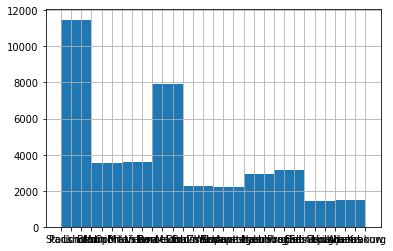

In [12]:
# Find how dense are restaurants in a given city
df['City'].hist()

density = {}

for index, value in df['City'].value_counts().iteritems():
    density[index] = int(round(value / 1000, 0))
    
df['Density'] = df['City'].apply(lambda city: density[city])

In [13]:
def tryParseReviewString(string_value, try_count=0):
  try:
    data = ast.literal_eval(string_value)
  except:
    if (try_count > 0): return [[],[]]
    # bad solution, but will work for now :)
    return tryParseReviewString(string_value.replace('nan', ''), 1)

  return data



def getLatestDateFromReview(review):
  data = tryParseReviewString(review)
  review_dates = data[1]
  if (len(review_dates) == 2):
    first_date = datetime.strptime(review_dates[0], '%m/%d/%Y')
    second_date = datetime.strptime(review_dates[1], '%m/%d/%Y')
    if (first_date > second_date): return first_date
    return second_date
  return float('NaN')



last_dates = df['Reviews'].apply(getLatestDateFromReview)
most_old_review = last_dates.min()
most_recent_review = last_dates.max()

print('Most recent review:', most_old_review)
print('Most old review:', most_recent_review)

Most recent review: 2008-04-07 00:00:00
Most old review: 2018-02-26 00:00:00


Review speed has NaN: False
LastReviewDate has NaN: False


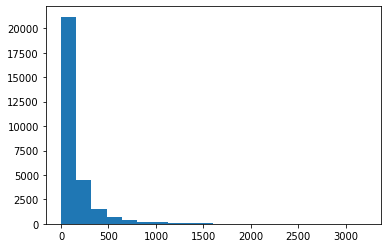

In [14]:
def  getReviewVelocity(review):
  data = tryParseReviewString(review)
  review_dates = data[1]
  if (len(review_dates) == 2):
    first_date = datetime.strptime(review_dates[0], '%m/%d/%Y')
    second_date = datetime.strptime(review_dates[1], '%m/%d/%Y')
    return abs((first_date - second_date).days)
  
  return float('NaN')


def howRecent(review):
  data = tryParseReviewString(review)
  review_dates = data[1]
  if (len(review_dates) == 2):
    first_date = datetime.strptime(review_dates[0], '%m/%d/%Y')
    second_date = datetime.strptime(review_dates[1], '%m/%d/%Y')
    recent_date = 0
    if (first_date > second_date):
      recent_date = first_date
    else:
      recent_date = second_date
    days = (most_recent_review - recent_date).days
    return days



review_speed = df['Reviews'].apply(getReviewVelocity)
how_recent_data = df['Reviews'].apply(howRecent)
plt.hist(review_speed, bins = 20)
# Based on the data given by diagram I want to replace all values higher than 
# 300 with 300
how_recent_data = how_recent_data.apply(removeBigValues, data=[300])
median_speed = review_speed.median()
review_speed = review_speed.fillna(median_speed)
how_recent_data = how_recent_data.fillna(how_recent_data.median())

df['ReviewSpeed'] = review_speed
df['LastReviewDate'] = how_recent_data

print('Review speed has NaN:', df['ReviewSpeed'].isnull().values.any())
print('LastReviewDate has NaN:', df['LastReviewDate'].isnull().values.any())

In [15]:
# Process review sentiment
# Get sentiment
def getSentiments(review):
  good = ['great', 'cool', 'nice', 'lovely', 'not bad', 'excellent', 'unique',
          'delicious', 'amazing', 'brillian', 'heavenly', 'gem', 'relaxing', 
          'fab', 'tasty', 'good']
  bad = ['wasting', 'waste', 'lack of', 'avoid', 'not ok', 'overpriced', 'terrible',
         'boring', 'don\'t go']
  review = review.lower()
  score = 0
  for word in good:
    if (word in review):
      score += 1
  for word in bad:
    if (word in review):
      score -= 1
  if (score > 0): return 1
  if (score < 0): return -1
  return 0



df['Sentiment'] = df['Reviews'].apply(getSentiments)

Visualization

In [16]:
# I find this table to be a more suitable way for me to find correlations
df.corr()

,Ranking,Rating,Price Range,Number of Reviews,Number_of_Reviews_isNAN,Price_Range_isNAN,Cuisine_Style_isNAN,CuisineCount,Density,ReviewSpeed,LastReviewDate,Sentiment
Ranking,1.000000,-0.368371,-0.220923,-0.210873,0.094078,0.233043,0.147995,-0.314553,0.704419,0.091472,0.176067,-0.160622
Rating,-0.368371,1.000000,0.031451,0.029255,0.008386,-0.064567,-0.038263,0.122325,-0.058177,-0.070799,-0.086818,0.145330
Price Range,-0.220923,0.031451,1.000000,0.284815,-0.190829,-0.675728,-0.510181,0.392035,0.035504,-0.085057,-0.148033,0.206981
Number of Reviews,-0.210873,0.029255,0.284815,1.000000,-0.009577,-0.242593,-0.185048,0.382451,0.028952,-0.133190,-0.254918,0.114665
Number_of_Reviews_isNAN,0.094078,0.008386,-0.190829,-0.009577,1.000000,0.266923,0.186118,-0.145354,-0.025326,-0.073759,-0.058295,-0.197509
Price_Range_isNAN,0.233043,-0.064567,-0.675728,-0.242593,0.266923,1.000000,0.753881,-0.430851,-0.048295,0.074541,0.133741,-0.280265
Cuisine_Style_isNAN,0.147995,-0.038263,-0.510181,-0.185048,0.186118,0.753881,1.000000,-0.284420,-0.047598,0.042117,0.097963,-0.193592
CuisineCount,-0.314553,0.122325,0.392035,0.382451,-0.145354,-0.430851,-0.284420,1.000000,-0.032723,-0.191718,-0.309746,0.222520
Density,0.704419,-0.058177,0.035504,0.028952,-0.025326,-0.048295,-0.047598,-0.032723,1.000000,-0.022274,-0.012562,0.024222
ReviewSpeed,0.091472,-0.070799,-0.085057,-0.133190,-0.073759,0.074541,0.042117,-0.191718,-0.022274,1.000000,0.281495,0.043108


In [17]:
# Work with city
df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)

In [18]:
def createCuisineMap():
    res = {}

    for key in unique_cuisines.keys():        
        res[key] = []
        for restaurant in cuisine_data:
            if key in restaurant:
                res[key].append(1)
            else:
                res[key].append(0)
    
    return res
                
extra_columns = createCuisineMap()

for column in extra_columns.keys():
    df[column] = extra_columns[column]

# Verify that data looks good   
display(df.head())

,Restaurant_id,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Number_of_Reviews_isNAN,Price_Range_isNAN,Cuisine_Style_isNAN,CuisineCount,Density,ReviewSpeed,LastReviewDate,Sentiment,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,...,Scottish,Arabic,Ukrainian,Chilean,Mongolian,Cuban,Persian,Indonesian,Colombian,Jamaican,Norwegian,Hawaiian,Armenian,Taiwanese,Bangladeshi,Sri Lankan,Cambodian,Albanian,New Zealand,Croatian,Central Asian,Filipino,Tunisian,Cajun & Creole,Romanian,Georgian,Polynesian,Azerbaijani,Caucasian,Afghani,Uzbek,Salvadoran,Yunnan,Native American,Canadian,Xinjiang,Burmese,Fujian,Welsh,Latvian
0,id_5569,"['European', 'French', 'International']",5570,3.5,2,194,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,0,0,3,5,41.0,57.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1535,NaN,1537,4.0,1,10,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,0,1,1,2,1,382.0,235.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_352,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353,4.5,3,688,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,0,0,0,7,6,2.0,49.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_3456,NaN,3458,5.0,1,3,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,0,1,1,2,2,67.0,136.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_615,"['German', 'Central European', 'Vegetarian Fri...",621,4.0,2,84,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,0,0,0,3,1,272.0,100.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# drop old columns
df = df.drop(axis=1, columns=['Cuisine Style', 'Reviews', 'URL_TA', 'ID_TA'])
# Verify that looks good
display(df.head())

,Restaurant_id,Ranking,Rating,Price Range,Number of Reviews,Number_of_Reviews_isNAN,Price_Range_isNAN,Cuisine_Style_isNAN,CuisineCount,Density,ReviewSpeed,LastReviewDate,Sentiment,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,...,Scottish,Arabic,Ukrainian,Chilean,Mongolian,Cuban,Persian,Indonesian,Colombian,Jamaican,Norwegian,Hawaiian,Armenian,Taiwanese,Bangladeshi,Sri Lankan,Cambodian,Albanian,New Zealand,Croatian,Central Asian,Filipino,Tunisian,Cajun & Creole,Romanian,Georgian,Polynesian,Azerbaijani,Caucasian,Afghani,Uzbek,Salvadoran,Yunnan,Native American,Canadian,Xinjiang,Burmese,Fujian,Welsh,Latvian
0,id_5569,5570,3.5,2,194,0,0,0,3,5,41.0,57.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1535,1537,4.0,1,10,0,1,1,2,1,382.0,235.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_352,353,4.5,3,688,0,0,0,7,6,2.0,49.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_3456,3458,5.0,1,3,0,1,1,2,2,67.0,136.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_615,621,4.0,2,84,0,0,0,3,1,272.0,100.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# Verify that there are no NaN
display(df.isnull().values.any())

False

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [21]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
y = df['Rating']

In [22]:
# Normalize X
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = scaler.fit_transform(X)

In [23]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [24]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [25]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [26]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [27]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20994700000000002
